# MNIST Training Notebook

Since my dataset of impressionist artworks is very large, I created this notebook where you can test the StyleGAN on a simpler dataset. I used the same hyperparameters for this (simpler) dataset as for the impressionist dataset. Therefore overfitting might occur.
I experience very unreliable and long calculations using FID on this dataset. Therefore I omitted it.

In [24]:
%load_ext autoreload
%autoreload 2

import torch
import MNISTDataset
import matplotlib.pyplot as plt
import generator
import discriminator
import globals
import math
import utils
from tqdm import tqdm
import importlib
import numpy as np
from utils_generator import g_loss_non_saturating, applyExponentialMovingAverage
from utils_discriminator import d_loss_non_saturating_r1
from ADA import ADA

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
importlib.reload(generator)
importlib.reload(discriminator)
importlib.reload(MNISTDataset)
importlib.reload(globals)
importlib.reload(utils)

<module 'utils' from 'c:\\Users\\alexa\\Desktop\\AppliedDeepLearning\\model\\utils.py'>

In [26]:
datasets = {
    4: MNISTDataset.MNISTDataset(resolution=4),
    8: MNISTDataset.MNISTDataset(resolution=8),
    16: MNISTDataset.MNISTDataset(resolution=16),
    32: MNISTDataset.MNISTDataset(resolution=32)
}

4x4 RESOLUTION


100%|██████████| 469/469 [00:59<00:00,  7.87it/s]


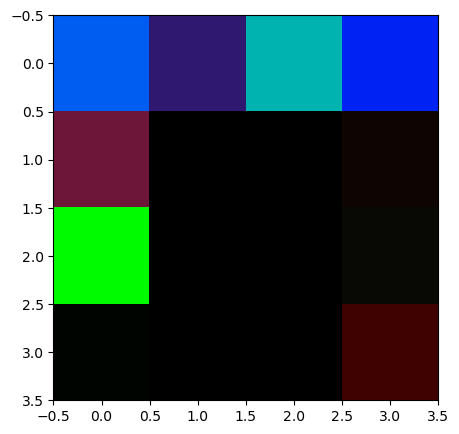

100%|██████████| 469/469 [00:59<00:00,  7.84it/s]


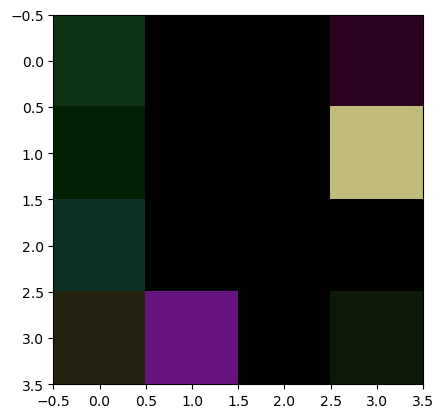

100%|██████████| 469/469 [00:59<00:00,  7.85it/s]


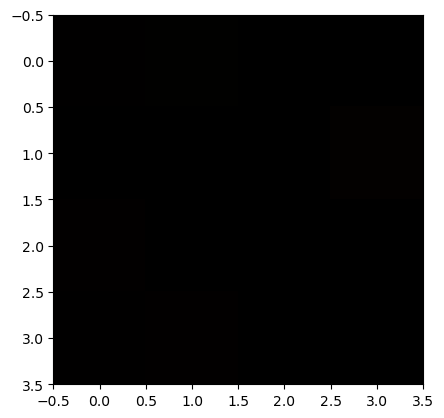

100%|██████████| 469/469 [01:00<00:00,  7.80it/s]


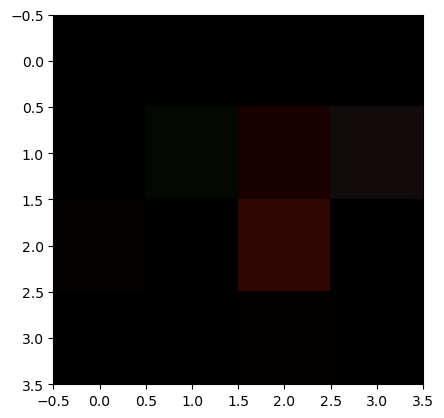

100%|██████████| 469/469 [01:00<00:00,  7.80it/s]


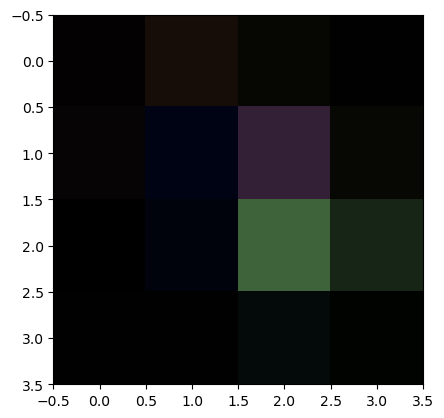

8x8 RESOLUTION


 11%|█         | 103/938 [00:31<04:14,  3.29it/s]


KeyboardInterrupt: 

In [28]:
plt.figure(figsize=(10, 5))

G = generator.Generator()
D = discriminator.Discriminator()
G.to(globals.DEVICE), D.to(globals.DEVICE)

G_EMA = generator.Generator()
G_EMA.load_state_dict(G.state_dict())
G_EMA.train(False)
G_EMA.to(globals.DEVICE)

for param in G_EMA.parameters():
    param.requires_grad_(False)

ada = ADA()

mapping_params, generator_params = utils.get_generator_params(G)

adam_g = torch.optim.Adam([
    {'params': mapping_params, 'lr': globals.LR_MAPPING_NETWORK},
    {'params': generator_params, 'lr': globals.LR_MODEL}
], betas=(globals.ADAM_BETA1, globals.ADAM_BETA2))

adam_d = torch.optim.Adam(D.parameters(), lr=globals.LR_MODEL, betas=(globals.ADAM_BETA1, globals.ADAM_BETA2))

res_list = [2**i for i in range(2, int(math.log2(globals.MAX_RES))+1)]

global_img_count = 0
for res in res_list:
    print(f"{res}x{res} RESOLUTION")
    if res > 4:
        G.fade_in(res)
        D.fade_in(res)
    
    batch_sizes = {
        4: 128,
        8: 64,
        16: 32,
        32: 16
    }
    loader = torch.utils.data.DataLoader(datasets[res], batch_size=batch_sizes[res], shuffle=True)

    fade_in_imgs = int(globals.IMAGES_PER_RESOLUTION[res] * globals.FADE_IN_PERCENTAGE)

    imgs_this_phase = 0
    discriminator_steps = 0
    count_until_fid = 70000
    while imgs_this_phase < globals.IMAGES_PER_RESOLUTION[res]:
        for real in tqdm(loader):
            real = real.to(globals.DEVICE)
            batch_size = real.size(0)

            if imgs_this_phase < fade_in_imgs:
                layer_opacity = min(1.0, imgs_this_phase / max(1, fade_in_imgs))
                G.set_layer_opacity(layer_opacity)
                D.set_layer_opacity(layer_opacity)
            else:
                G.set_layer_opacity(1.0)
                D.set_layer_opacity(1.0)

            for _ in range(globals.DISCRIMINATOR_STEPS):
                # Discriminator step
                z = torch.randn(batch_size, globals.Z_DIM, device=globals.DEVICE)
                with torch.no_grad():
                    fake = G(z)
                D_loss = d_loss_non_saturating_r1(D, real, fake.detach(), d_step=discriminator_steps, ada=ada)
                adam_d.zero_grad(set_to_none=True)
                D_loss.backward(retain_graph=False)
                adam_d.step()

            # Generator step
            z = torch.randn(batch_size, globals.Z_DIM, device=globals.DEVICE)
            fake = G(z)
            G_loss = g_loss_non_saturating(D, fake, ada)
            adam_g.zero_grad(set_to_none=True)
            G_loss.backward()
            adam_g.step()
            applyExponentialMovingAverage(G, G_EMA)

            imgs_this_phase += batch_size
            global_img_count += batch_size

        # visualizing output
        z_test = torch.randn(1, globals.Z_DIM, device=globals.DEVICE)
        fake_test = G(z_test)
        img = (fake_test[0] + 1) / 2.0
        img = np.transpose(img.detach().cpu().numpy(), (1, 2, 0))
        plt.imshow(img)
        plt.show()

    G.set_layer_opacity(1.0)
    D.set_layer_opacity(1.0)